In [2]:
#here we are using MobileNetV2 model first

In [4]:
#Training - Fine-Tuned MobileNetV2 with Regularization and Data Augmentation

Found 2620 images belonging to 6 classes.
Found 120 images belonging to 6 classes.
Found 126 images belonging to 6 classes.
Epoch 1/10


C:\Users\sayal\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


82/82 ━━━━━━━━━━━━━━━━━━━━ 252s 3s/step - accuracy: 0.4533 - loss: 3.5540 - val_accuracy: 0.6333 - val_loss: 2.2117
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 247s 3s/step - accuracy: 0.6627 - loss: 2.0193 - val_accuracy: 0.6833 - val_loss: 1.7132
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.7225 - loss: 1.5072 - val_accuracy: 0.7250 - val_loss: 1.4729
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.7529 - loss: 1.2502 - val_accuracy: 0.7000 - val_loss: 1.2666
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.7624 - loss: 1.0921 - val_accuracy: 0.6917 - val_loss: 1.2475
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 213s 2s/step - accuracy: 0.7548 - loss: 1.0173 - val_accuracy: 0.6667 - val_loss: 1.2530
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.7844 - loss: 0.9267 - val_accuracy: 0.6917 - val_loss: 1.1653
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.7542 - loss: 0.9535 - val_accuracy: 0.7500 - val_loss: 1.

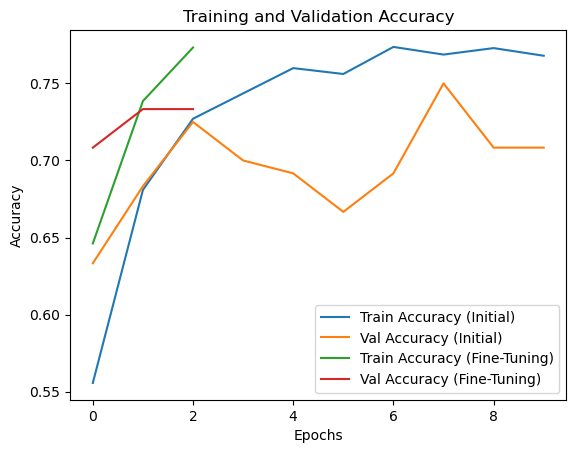

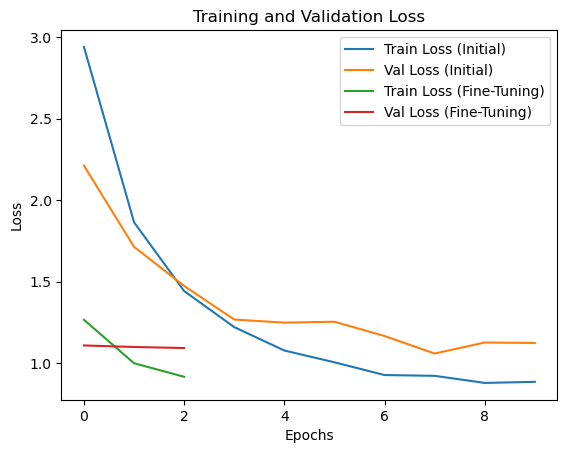

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Paths
train_dir = r"C:\Users\sayal\Desktop\Medicinal Plant Dataset\Split_Dataset\train"
val_dir = r"C:\Users\sayal\Desktop\Medicinal Plant Dataset\Split_Dataset\val"
test_dir = r"C:\Users\sayal\Desktop\Medicinal Plant Dataset\Split_Dataset\test"

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Data Generators
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Load Pretrained MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze Base Model Layers Initially
base_model.trainable = False

# Add Classification Head with Regularization
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(6, activation='softmax')  # 7 classes
])

# Compile the Model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the Model (Initial Training with Frozen Base)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,  # Initial Training
    callbacks=[early_stopping]
)

# Fine-Tune the Base Model (Unfreeze Last Few Layers)
base_model.trainable = True
for layer in base_model.layers[:-50]:  # Freeze all but the last 50 layers
    layer.trainable = False

# Recompile the Model with Lower Learning Rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-Tune the Model
fine_tune_history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5,  # Fine-Tuning
    callbacks=[early_stopping]
)

# Evaluate on Test Set
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy after Fine-Tuning: {test_acc:.4f}")

# Visualize Training Progress
import matplotlib.pyplot as plt

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy (Initial)')
plt.plot(history.history['val_accuracy'], label='Val Accuracy (Initial)')
plt.plot(fine_tune_history.history['accuracy'], label='Train Accuracy (Fine-Tuning)')
plt.plot(fine_tune_history.history['val_accuracy'], label='Val Accuracy (Fine-Tuning)')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Train Loss (Initial)')
plt.plot(history.history['val_loss'], label='Val Loss (Initial)')
plt.plot(fine_tune_history.history['loss'], label='Train Loss (Fine-Tuning)')
plt.plot(fine_tune_history.history['val_loss'], label='Val Loss (Fine-Tuning)')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


In [8]:
from tensorflow.keras.models import save_model

# Save the trained model to a file
model.save("mobilenetv2_model.h5")

print("Model saved as mobilenetv2_model.h5")


Model saved as mobilenetv2_model.h5


In [10]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("mobilenetv2_model.h5")

print("Model loaded successfully")


Model loaded successfully


In [12]:
# Test the loaded model
import numpy as np

# Assuming test_data is already prepared
predictions = model.predict(test_data)
predicted_class = np.argmax(predictions, axis=1)

print(f"Sample Prediction: {predicted_class[0]}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step
Sample Prediction: 1


In [14]:
# Evaluate Performance:

SyntaxError: invalid syntax (1699572287.py, line 1)

In [16]:
from sklearn.metrics import classification_report

# Get true labels and predictions
y_true = test_data.classes
y_pred = np.argmax(model.predict(test_data), axis=1)

# Generate a classification report
print(classification_report(y_true, y_pred, target_names=test_data.class_indices.keys()))


4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step
                                     precision    recall  f1-score   support

                    Basil - Healthy       0.23      0.21      0.22        38
      Diseased Basil - Downy Mildew       0.15      0.20      0.17        15
     Diseased Basil - Fusarium Wilt       0.17      0.19      0.18        36
         Diseased Basil - Gray Mold       0.21      0.20      0.21        15
Diseased Basil - Septoria leaf spot       0.00      0.00      0.00         4
           Diseased Basil - Sunburn       0.12      0.11      0.11        18

                           accuracy                           0.18       126
                          macro avg       0.15      0.15      0.15       126
                       weighted avg       0.18      0.18      0.18       126



C:\Users\sayal\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sayal\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sayal\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [18]:
from tensorflow.keras.models import save_model

# Save the model to an .h5 file
model.save("mobilenetv2_model.h5")
print("Model saved as mobilenetv2_model.h5")


Model saved as mobilenetv2_model.h5


In [20]:
import os
print(os.getcwd())  # Displays the current working directory


C:\Users\sayal


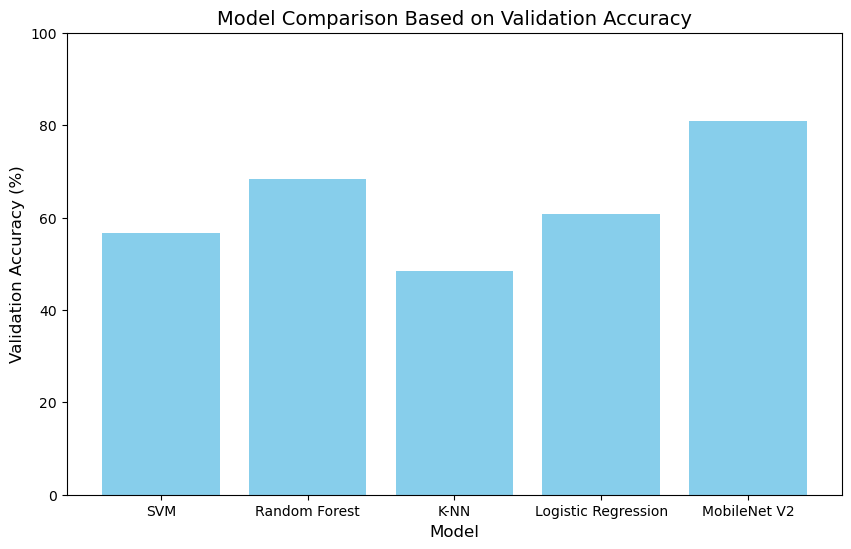

In [1]:
import matplotlib.pyplot as plt

# Data from the table
models = ['SVM', 'Random Forest', 'K-NN', 'Logistic Regression', 'MobileNet V2']
accuracy = [56.67, 68.33, 48.33, 60.83, 80.95]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(models, accuracy, color='skyblue')

# Adding labels and title
plt.title('Model Comparison Based on Validation Accuracy', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Validation Accuracy (%)', fontsize=12)
plt.ylim(0, 100)  # Setting y-axis limit from 0 to 100

# Display the graph
plt.show()
